In [617]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.circuit import ParameterVector, Parameter
from qiskit_algorithms.optimizers import COBYLA
import numpy as np
import math
import matplotlib.pyplot as plt

In [618]:
def create_unitary_evolution(num_address_qubits, num_embedding_qubits, evolution_indice=1):
    # Define quantum registers
    q_reg_address = QuantumRegister(num_address_qubits, name='q')
    q_reg_embedding = QuantumRegister(num_embedding_qubits, name='e')

    # Create a quantum circuit
    u1_qc = QuantumCircuit(q_reg_address, q_reg_embedding, name=str('U' + evolution_indice))

    # hadamat gate on all address qubits
    u1_qc.h(q_reg_address[:])
    # perform rotation on each address qubit with corresponding embedding qubit by theta
    for i in range(1):
        theta_params = [Parameter(f'theta_{evolution_indice}_{j}') for j in range(num_address_qubits)]
    
    for i in range(num_address_qubits - 1, -1, -1):
        u1_qc.cry(theta_params[i], i, num_address_qubits)
    # u1_qc.measure(q_reg_address[:], q_reg_embedding[:])
    
    # draw the custom circuit
    display(u1_qc.draw('mpl'))
    
    # return u1_qc.to_instruction()
    u_gate = u1_qc.to_gate()
    controlled_u_gate = u_gate.control(1)
    return controlled_u_gate

/Users/andycaen/opt/anaconda3/lib/python3.8/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


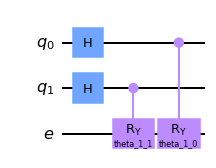

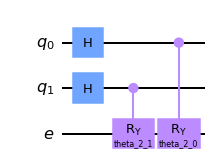

In [619]:
# Example 
num_ancilla_qubits = 1
num_address_qubits = 2
num_embedding_qubits = 1
u1_gate = create_unitary_evolution(num_address_qubits, num_embedding_qubits, '1')
u2_gate = create_unitary_evolution(num_address_qubits, num_embedding_qubits, '2')
# Display the circuit
# print(custom_gate)

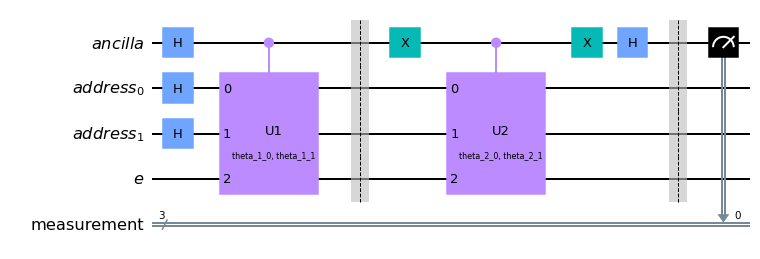

In [620]:
from qiskit.circuit.library import XGate  # Create QuantumRegisters
num_ancilla_qubits = 1
num_address_qubits = 2
num_embedding_qubits = 1
q_reg_ancilla = QuantumRegister(num_ancilla_qubits, name='ancilla')
q_reg_address = QuantumRegister(num_address_qubits, name='address')
q_reg_embedding = QuantumRegister(num_embedding_qubits, name='e')

# Create ClassicalRegister for measurement if needed
cr_measurement = ClassicalRegister(num_ancilla_qubits + num_address_qubits, name='measurement')

# Create QuantumCircuit
qc = QuantumCircuit(q_reg_ancilla, q_reg_address, q_reg_embedding, cr_measurement)

# Apply Hadamard gate to all ancilla qubits
qc.h(q_reg_ancilla[:])
qc.h(q_reg_address[:])

# cx gate between ancilla and all address qubits



# qc.cx(qreg_ancilla[:], q_reg_address[:] + q_reg_embedding[:])

# Append your custom u1 and u2 instructions to the circuit
qc.append(u1_gate, q_reg_ancilla[:] + q_reg_address[:] + q_reg_embedding[:])

# qc.ccx(qreg_ancilla[:], q_reg_address[:] + q_reg_embedding[:])

# anti_gate = XGate.control(ctrl_state='0', annotated='x')
# circuit.append(anti_gate, [qreg_ancilla[:], q_reg_address[:] + q_reg_embedding[:]])
qc.barrier()
# negative control workaround ? 
# x cx x
# qc.x(qreg_ancilla[:])
# qc.cx(qreg_ancilla[:], q_reg_address[:] + q_reg_embedding[:])
# qc.x(qreg_ancilla[:])
# qc.barrier()

qc.x(q_reg_ancilla[:])
qc.append(u2_gate, q_reg_ancilla[:] + q_reg_address[:] + q_reg_embedding[:])
qc.x(q_reg_ancilla[:])


qc.h(q_reg_ancilla[:])

qc.barrier()


qc.measure(q_reg_ancilla[:], cr_measurement[0])
# qc.measure(q_reg_address[:], cr_measurement[1:])

display(qc.draw('mpl'))

In [621]:
import numpy as np
from qiskit import QuantumCircuit, Aer, execute, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Operator


In [622]:
def G_gate(alpha, beta, gamma):
    return np.array([
        [np.exp(1j*beta) * np.cos(alpha), np.exp(1j*gamma) * np.sin(alpha)],
        [-np.exp(-1j*gamma) * np.sin(alpha), np.exp(-1j*beta) * np.cos(alpha)]
    ])


In [623]:
def controlled_G_gate(alpha, beta, gamma):
    # Define the 4x4 matrix for the controlled G gate
    cg = np.eye(4, dtype=np.complex128)  # Start with an identity matrix
    g = G_gate(alpha, beta, gamma)
    cg[2:4, 2:4] = g  # Place the G gate in the bottom right corner for control on |1>
    return cg


In [624]:
def derivative_G_gate(alpha, beta, gamma, param):
    delta = np.pi / 2
    if param == 'alpha':
        return G_gate(alpha + delta, beta, gamma)
    elif param == 'beta':
        return G_gate(alpha, beta + delta, np.pi)/2 + G_gate(alpha, beta + delta, 0)/2
    elif param == 'gamma':
        return G_gate(alpha, 0, gamma + delta)/2 - G_gate(alpha, np.pi, gamma + delta)/2


In [625]:
import numpy as np

def loss_function(y_true, y_pred, kappa):
    """
    Compute the custom loss function for the quantum circuit embedding model.
    
    Parameters:
    - y_true: array of true labels (numpy array)
    - y_pred: array of predicted labels from the quantum model (numpy array)
    - kappa: hyperparameter, positive integer
    
    Returns:
    - Loss value as a float
    """
    # Compute the loss component-wise
    loss = np.mean((y_true - y_pred) ** (2 * kappa))
    return loss


In [626]:
import hashlib
import numpy as np

def string_to_parameters(entity, num_gates=24):
    """ Convert a string into a list of (alpha, beta, gamma) tuples for gate parameters. """
    hash_object = hashlib.sha256(entity.encode())
    hex_dig = hash_object.hexdigest()
    seed = int(hex_dig[:8], 16) 
    np.random.seed(seed)  # Use hash to seed random number generation for consistency
    return [[np.random.rand() * np.pi, np.random.rand() * 2 * np.pi, np.random.rand() * 2 * np.pi] for _ in range(num_gates)]



In [627]:
from itertools import product

# Define relationships
relationships = [
    ("Christopher", "Arthur", "father"), 
    ("Christopher", "Victoria", "father"),
    ("Andrew", "James", "father"),
    ("Andrew", "Jennifer", "father"),
    ("James", "Colin", "father"),
    ("James", "Charlotte", "father"),
    ("Roberto", "Emilio", "father"),
    ("Roberto", "Lucia", "father"),
    ("Pierro", "Marco", "father"),
    ("Pierro", "Angela", "father"),
    ("Marco", "Alfonso", "father"),
    ("Marco", "Sophia", "father"),

    ("Penelope", "Arthur", "mother"),
    ("Penelope", "Victoria", "mother"),
    ("Christine", "James", "mother"),
    ("Christine", "Jennifer", "mother"),
    ("Victoria", "Colin", "mother"),
    ("Victoria", "Charlotte", "mother"),
    ("Maria", "Emilio", "mother"),
    ("Maria", "Lucia", "mother"),
    ("Francesca", "Marco", "mother"),
    ("Francesca", "Angela", "mother"),
    ("Lucia", "Alfonso", "mother"),
    ("Lucia", "Sophia", "mother"),

    ("Christopher", "Penelope", "husband"),
    ("Andrew", "Christine", "husband"),
    ("Arthur", "Margaret", "husband"),
    ("James", "Victoria", "husband"),
    ("Charles", "Jennifer", "husband"),
    ("Roberto", "Maria", "husband"),
    ("Pierro", "Francesca", "husband"),
    ("Emilio", "Gina", "husband"),
    ("Marco", "Lucia", "husband"),
    ("Tomaso", "Angela", "husband"),

    ("Penelope", "Christopher", "wife"),
    ("Christine", "Andrew", "wife"),
    ("Margaret", "Arthur", "wife"),
    ("Victoria", "James", "wife"),
    ("Jennifer", "Charles", "wife"),
    ("Maria", "Roberto", "wife"),
    ("Francesca", "Pierro", "wife"),
    ("Gina", "Emilio", "wife"),
    ("Lucia", "Marco", "wife"),
    ("Angela", "Tomaso", "wife"),

    ("Arthur", "Christopher", "son"),
    ("Arthur", "Penelope", "son"),
    ("James", "Andrew", "son"),
    ("James", "Christine", "son"),
    ("Colin", "Victoria", "son"),
    ("Colin", "James", "son"),
    ("Emilio", "Roberto", "son"),
    ("Emilio", "Maria", "son"),
    ("Marco", "Pierro", "son"),
    ("Marco", "Francesca", "son"),
    ("Alfonso", "Lucia", "son"),
    ("Alfonso", "Marco", "son"),

    ("Victoria", "Christopher", "daughter"),
    ("Victoria", "Penelope", "daughter"),
    ("Jennifer", "Andrew", "daughter"),
    ("Jennifer", "Christine", "daughter"),
    ("Charlotte", "Victoria", "daughter"),
    ("Charlotte", "James", "daughter"),
    ("Lucia", "Roberto", "daughter"),
    ("Lucia", "Maria", "daughter"),
    ("Angela", "Pierro", "daughter"),
    ("Angela", "Francesca", "daughter"),
    ("Sophia", "Lucia", "daughter"),
    ("Sophia", "Marco", "daughter"),

    ("Arthur", "Victoria", "brother"),
    ("James", "Jennifer", "brother"),
    ("Colin", "Charlotte", "brother"),
    ("Emilio", "Lucia", "brother"),
    ("Marco", "Angela", "brother"),
    ("Alfonso", "Sophia", "brother"),

    ("Victoria", "Arthur", "sister"),
    ("Jennifer", "James", "sister"),
    ("Charlotte", "Colin", "sister"),
    ("Lucia", "Emilio", "sister"),
    ("Angela", "Marco", "sister"),
    ("Sophia", "Alfonso", "sister"),

    ("Arthur", "Colin", "uncle"),
    ("Charles", "Colin", "uncle"),
    ("Arthur", "Charlotte", "uncle"),
    ("Charles", "Charlotte", "uncle"),
    ("Emilio", "Alfonso", "uncle"),
    ("Tomaso", "Alfonso", "uncle"),
    ("Emilio", "Sophia", "uncle"),
    ("Tomaso", "Sophia", "uncle"),

    ("Jennifer", "Colin", "aunt"),
    ("Margaret", "Colin", "aunt"),
    ("Jennifer", "Charlotte", "aunt"),
    ("Margaret", "Charlotte", "aunt"),
    ("Angela", "Alfonso", "aunt"),
    ("Gina", "Alfonso", "aunt"),
    ("Angela", "Sophia", "aunt"),
    ("Gina", "Sophia", "aunt"),

    ("Colin", "Arthur", "nephew"),
    ("Colin", "Jennifer", "nephew"),
    ("Alfonso", "Emilio", "nephew"),
    ("Alfonso", "Angela", "nephew"),
    ("Colin", "Margaret", "nephew"),
    ("Colin", "Charles", "nephew"),
    ("Alfonso", "Gina", "nephew"),
    ("Alfonso", "Tomaso", "nephew"),

    ("Charlotte", "Arthur", "niece"),
    ("Charlotte", "Jennifer", "niece"),
    ("Sophia", "Emilio", "niece"),
    ("Sophia", "Angela", "niece"),
    ("Charlotte", "Margaret", "niece"),
    ("Charlotte", "Charles", "niece"),
    ("Sophia", "Gina", "niece"),
    ("Sophia", "Tomaso", "niece"),
]

relationship_dict = {tuple(rel): 1 for rel in relationships}

# Extract unique subjects, predicates, and objects
subjects = set(r[0] for r in relationships)
objects = set(r[1] for r in relationships)
predicates = set(r[2] for r in relationships)


# Generate all possible combinations
all_combinations = product(subjects, objects, predicates)

# Filter out the existing true relationships and label them as false (-1)
for combo in all_combinations:
    if combo not in relationship_dict:
        relationship_dict[combo] = -1

# print(relationship_dict)

In [628]:
def create_unitary_circuit_subject_plus_predicate(params_subject, params_predicate, label):
    n_qubits = 6  # Total number of qubits
    qc = QuantumCircuit(n_qubits, name=label)
    
    for i in range(n_qubits):
        qc.h(i)

    # Apply a normal G gate to each qubit
    for i in range(n_qubits):
        alpha, beta, gamma = params_subject[i]  # Use modulo to cycle through params if not enough sets
        G = G_gate(alpha, beta, gamma)
        qc.unitary(Operator(G), [i], label=f'G({alpha},{beta},{gamma})')


    # Define the specific order of controlled gates, (controller, target) pairs
    controlled_gate_pairs = [
        (5, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 5),  # Circular pattern
        (4, 0), (5, 1), (0, 2), (1, 3), (2, 4), (3, 5),  # Cross pattern
        (3, 0), (4, 1), (5, 2), (0, 3), (1, 4), (2, 5)   # Additional cross control gates
    ]

    # Apply controlled G gates in the specified order
    for idx, (ctrl, tgt) in enumerate(controlled_gate_pairs):
        alpha, beta, gamma = params_subject[idx + n_qubits]
        cG = controlled_G_gate(alpha, beta, gamma)
        qc.unitary(Operator(cG), [ctrl, tgt], label=f'cG({alpha},{beta},{gamma}) from {ctrl} to {tgt}')
    
    # Apply a normal G gate to each qubit
    for i in range(6):
        alpha, beta, gamma = params_subject[i]  # Use modulo to cycle through params if not enough sets
        G = G_gate(alpha, beta, gamma)
        qc.unitary(Operator(G), [i], label=f'G({alpha},{beta},{gamma})')
    
    for idx, (ctrl, tgt) in enumerate(controlled_gate_pairs):
        alpha, beta, gamma = params_predicate[idx]
        cG = controlled_G_gate(alpha, beta, gamma)
        qc.unitary(Operator(cG), [ctrl, tgt], label=f'cG({alpha},{beta},{gamma}) from {ctrl} to {tgt}')
    
    
    return qc

def create_unitary_circuit_object(params_object, label):
    n_qubits = 6  # Total number of qubits
    qc = QuantumCircuit(n_qubits, name=label)
    
    for i in range(n_qubits):
        qc.h(i)

    # Apply a normal G gate to each qubit
    for i in range(n_qubits):
        alpha, beta, gamma = params_object[i]  # Use modulo to cycle through params if not enough sets
        G = G_gate(alpha, beta, gamma)
        qc.unitary(Operator(G), [i], label=f'G({alpha},{beta},{gamma})')


    # Define the specific order of controlled gates, (controller, target) pairs
    controlled_gate_pairs = [
        (5, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 5),  # Circular pattern
        (4, 0), (5, 1), (0, 2), (1, 3), (2, 4), (3, 5),  # Cross pattern
        (3, 0), (4, 1), (5, 2), (0, 3), (1, 4), (2, 5)   # Additional cross control gates
    ]

    # Apply controlled G gates in the specified order
    for idx, (ctrl, tgt) in enumerate(controlled_gate_pairs):
        alpha, beta, gamma = params_object[idx]
        cG = controlled_G_gate(alpha, beta, gamma)
        qc.unitary(Operator(cG), [ctrl, tgt], label=f'cG({alpha},{beta},{gamma}) from {ctrl} to {tgt}')
    
    return qc





In [629]:
def setup_quantum_circuit(params_subject, params_predicate, params_object):

    # Create the quantum circuit
    u1 = create_unitary_circuit_subject_plus_predicate(params_subject, params_predicate, 'U1')
    u2 = create_unitary_circuit_object(params_object, 'U2')

    creg = ClassicalRegister(1, 'creg')
    main_qubits = QuantumRegister(6, 'main_qubits')
    ancilla = QuantumRegister(1, 'ancilla')

    qc = QuantumCircuit(ancilla, main_qubits, creg)
    qc.h(ancilla[0])
    qc.append(u1.to_gate().control(), [ancilla[0]] + list(range(1, 7)))
    qc.x(ancilla[0])
    qc.append(u2.to_gate().control(), [ancilla[0]] + list(range(1, 7)))
    qc.x(ancilla[0])
    qc.h(ancilla[0])
    qc.measure(ancilla[0], creg[0])

    return qc

In [630]:
def run_circuit_and_compute_loss(qc, true_value, kappa=1):
    """
    Runs a quantum circuit, measures the outcome, and computes the loss.

    Parameters:
    - qc: QuantumCircuit, the quantum circuit to be executed.
    - true_value: float, the true value against which the measurement is compared.
    - kappa: int, the hyperparameter for the loss function power.

    Returns:
    - loss: float, the computed loss value.
    - measured_value: float, the value derived from the quantum measurement.
    """
    # Run the circuit using the qasm simulator
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=1000)
    result = job.result()
    counts = result.get_counts(qc)
    
    # Calculate the proportion of '0's measured
    proportion_0s = counts.get('0', 0) / sum(counts.values())
    
    # Convert this proportion to a value in the range [-1, 1]
    measured_value = 2 * proportion_0s - 1
    
    # Compute the loss using a simple squared error raised to the power of kappa
    loss = np.mean((np.array([true_value]) - np.array([measured_value])) ** (2 * kappa))
    
    return loss, measured_value

In [631]:
def update_parameter(params, index, delta, learning_rate=0.1):
    """ Update a single parameter and return the updated list. """
    original_value = params[index]
    params[index] += learning_rate * delta  # Apply update
    return params, original_value  # Return updated params and original value for potential revert

In [632]:
def test_parameter_update(circuit_setup, params, learning_rate, true_value):
    """ Test updating each parameter type (alpha, beta, gamma) independently and keep the best. """
    min_loss = float('inf')

    params_subject, params_predicate, params_object = params

    best_params = params_object.copy()


    for i in range(len(params_object)):  # Iterate over each set of parameters
        # Try updating each parameter type
        
        for pt in range(3):
            trial_params = best_params.copy()
            _, original_value = update_parameter(trial_params[i], pt, np.pi / 2, learning_rate)
            qc = circuit_setup(params_subject, params_predicate, trial_params)  # Setup the circuit with new parameters
            loss, measured_value = run_circuit_and_compute_loss(qc, true_value)  # Function to execute the circuit and calculate loss

            if loss < min_loss:
                min_loss = loss
                best_params = trial_params
            else:
                trial_params[i][pt] = original_value  # Revert if not the best


    return best_params, min_loss

('Christopher', 'Arthur', 'father')
Measured Value: -0.04200000000000004, Loss: 1.0857640000000002
Measured Value: 0.04600000000000004, Loss: 0.9101159999999999
Measured Value: 0.0020000000000000018, Loss: 0.996004
Measured Value: 0.05600000000000005, Loss: 0.8911359999999999
Measured Value: 0.07600000000000007, Loss: 0.8537759999999999
Measured Value: 0.06400000000000006, Loss: 0.8760959999999999
Measured Value: 0.15799999999999992, Loss: 0.7089640000000001
Measured Value: 0.1359999999999999, Loss: 0.7464960000000002
Measured Value: 0.19799999999999995, Loss: 0.6432040000000001
Measured Value: 0.18999999999999995, Loss: 0.6561000000000001
Measured Value: 0.248, Loss: 0.565504
Measured Value: 0.20199999999999996, Loss: 0.636804
Measured Value: 0.18599999999999994, Loss: 0.6625960000000001
Measured Value: 0.28, Loss: 0.5184
Measured Value: 0.15999999999999992, Loss: 0.7056000000000001
Measured Value: 0.242, Loss: 0.574564
Measured Value: 0.28200000000000003, Loss: 0.515524
Measured Valu

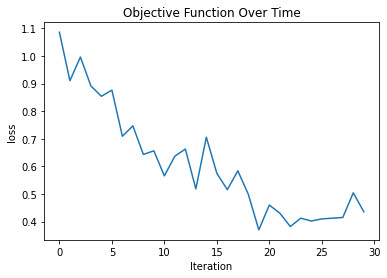

In [633]:
triple = relationships[0]

print(triple)

params_subject = string_to_parameters(triple[0])
params_predicate = string_to_parameters(triple[2])
params_object = string_to_parameters(triple[1])

loss_values = []


for i in range(30):
    true_value = relationship_dict.get(triple, -1)  # Example of getting the true value
    qc = setup_quantum_circuit(params_subject, params_predicate, params_object)  # Setup the circuit
    loss, measured_value = run_circuit_and_compute_loss(qc, true_value)
    params_object, min_loss = test_parameter_update(setup_quantum_circuit, (params_subject, params_predicate, params_object), 'object', 0.1, true_value)
    print(f"Measured Value: {measured_value}, Loss: {loss}")
    loss_values.append(loss)

plt.plot(loss_values)
plt.xlabel('Iteration')
plt.ylabel("loss")
plt.title('Objective Function Over Time')
plt.show()

    
    